### **Importing data from kaggle**

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tsameema/ant-bbox-keypoint-for-yolov8
! mkdir train
! unzip ant-bbox-keypoint-for-yolov8.zip -d ant-bbox-keypoint-for-yolov8

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.0/617.0 kB 6.0 MB/s eta 0:00:00


### **Importing Python Libraries**

In [ ]:
import ultralytics, os, cv2, glob, yaml
from ultralytics import YOLO
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error as mse

In [ ]:
#checking the number of files present in each folder
image_path = '/content/ant-bbox-keypoint-for-yolov8/ant_bbox_keypoint/images'
for mode in  ['train', 'val', 'test']:
  filenum = len(os.listdir(os.path.join(image_path, mode)))
  print(f'Number of files in {mode} : {filenum}')

Number of files in train : 431
Number of files in val : 49
Number of files in test : 120


In [ ]:
#checking the size of each image
for mode in  ['train', 'val', 'test']:
  imsize = (0, 0, 0)
  for f in glob.glob(os.path.join(image_path, mode, '*')):
    img = cv2.imread(f).shape
    if img != imsize:
      print(img)
      imsize = img

(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)


## **Plotting original image with bbox**

In [ ]:
pip install --upgrade opencv-python matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 21.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


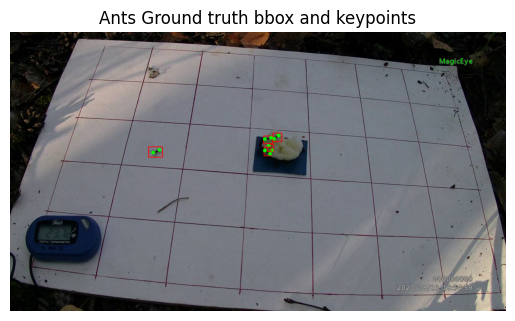

In [ ]:
def read_plot_image_label(image_path, label_path):
  """
  Read image and its cooresponding label files gorund truth, visualizes bounding box coordinates
  and keypoints of objects present through matplotlib

  Args:
    image_path (str) : path of image file
    label_path (str) : path of label file

  Returns:
    None
  """
  #read image file
  img = cv2.imread(image_path)
  #read label file
  label_list = []
  with open(label_path, 'r') as f:
    lines = f.read().strip().split('\n')
  #Extracting class, bboxes and keypoints for each object present in image
  for line in lines:
    label_dict = {}
    int_labels = [int(n) for n in line.split()]
    label_dict['cls'] = int_labels[0]
    label_dict['bbox'] = int_labels[1:5]
    label_dict['keypoint'] = (int_labels[5:7], int_labels[7:])
    label_list.append(label_dict)
  #Visualize bboxes and keypoints
  for list_val in label_list:
    bbox = list_val['bbox']
    kp = list_val['keypoint']
    img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 255), 2)
    img = cv2.circle(img, kp[0], 2, (0,255, 0), 10)
    img = cv2.circle(img, kp[1], 2, (0,255, 0), 10)
  # Convert the image to RGB format for displaying with matplotlib
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # Display the image
  plt.imshow(img_rgb)
  plt.axis('off')
  plt.title("Ants Ground truth bbox and keypoints")
  plt.show()


plot_image_path = '/content/ant-bbox-keypoint-for-yolov8/ant_bbox_keypoint/images/test/image499.png'
plot_label_path = '/content/ant-bbox-keypoint-for-yolov8/ant_bbox_keypoint/labels/test/bbox_keypoint_499.txt'
read_plot_image_label(plot_image_path, plot_label_path)


# **APPLYING ALBUMENTATION**

In [ ]:
def read_label_file(path):
  """
  Reads ground truth label file, convert the data from string to int, and remove all the
  unnecessary text
  Args:
      file (str): path of label file
  Returns:
      list: A list of ground truth in formated way

  """
  with open(path, 'r') as f:
        lines = f.read().strip().split('\n')
        keypoint = [list(map(int, line.split())) for line in lines]
  return keypoint

def combine_cls_bbox_kp(data):
  """
  Combines class, bbox, and keypoint labels into a single line after applying Albumentations
  transformations.

  Args:
        data (tuple): A tuple containing class label, bounding box, and keypoint data.

  Returns:
        str: A string containing the combined labels in a single line.

  """
  class_data, bbox_data, keypoint_data = data
  all_labels = [str(class_data)]

  for bbox in bbox_data[0]:
    all_labels.append(str(bbox))

  for key_pt in keypoint_data:
    all_labels.extend(map(str, key_pt))

  return ' '.join(all_labels)

def converted_bbox(bbox, img_height, img_width):
  """
  convert the bbox into required YOLO format
  given : [xmin, xmax, ymin, ymax]
  required : [xcenter, ycenter, width, height]

  Args:
    bbox (list) : A list containing bounding box coordinates [xmin, xmax, ymin, ymax]
    img_height (int) : Height of image
    img_width (int)  : Width of image

  Returns:
    tuple :  A tuple containing YOLO format bounding boxes coordinates [xcenter, ycenter, width, height]
  """
  x_min, y_min, x_max, y_max = bbox[0]
  x_center = (( x_min + x_max ) / 2 ) / img_width
  y_center = (( y_min + y_max ) / 2 ) / img_height
  width = ( x_max - x_min) / img_width
  height = ( y_max - y_min ) / img_height
  return (x_center), (y_center), (width), (height)

### **Creating directories**

In [ ]:
# Define the base directory
base_directory = '/content/ant-bbox-keypoint-for-yolov8/ant_albumentation'

# Create the base directory if it doesn't exist
if not os.path.exists(base_directory):
    os.mkdir(base_directory)

# Define the image and label directories
image_dir = os.path.join(base_directory, 'images')
label_dir = os.path.join(base_directory, 'labels')

# Create the image directory if it doesn't exist
if not os.path.exists(image_dir):
    os.mkdir(image_dir)

# Create the label directory if it doesn't exist
if not os.path.exists(label_dir):
    os.mkdir(label_dir)


### **Creating Albumentation Pipeline**

In [ ]:
def create_albumentation_pipeline(kp_labels, kp_sides, bbox_labels):
  """
  Create an albumentation pipeline as image is resized

  Args:
    kp_label (list) : A list contains labels for the keypoints either abdomen or head
    kp_sides (list) : A list takes sides of the keypoints either top or bottom
    bbox_labels (list) : A list contains class to which bbox belongs

  Returns:
    A.Compose: An Albumentations pipeline for image augmentation.

  """

  # Define image dimensions
  A_HEIGHT, A_WIDTH = 512, 640

  # Create the Albumentations pipeline
  transform =  A.Compose([
      A.Resize(A_HEIGHT, A_WIDTH)
      ],
      bbox_params=A.BboxParams(
          format='yolo',
          label_fields = ['bbox_labels'],
      ),
      keypoint_params=A.KeypointParams(
          format='xy',
          label_fields=['kp_labels', 'kp_sides'],
          remove_invisible=True,
      ))
  return transform


In [ ]:
label_path = '/content/ant-bbox-keypoint-for-yolov8/ant_bbox_keypoint/labels'
image_path = '/content/ant-bbox-keypoint-for-yolov8/ant_bbox_keypoint/images'

# Define orignal size of image
img_read = cv2.imread(plot_image_path)
HEIGHT, WIDHT, _ = img_read.shape

# Define labels for keypoints and bounding boxes
A_HEIGHT, A_WIDTH = 512, 640
kp_labels = ['abdomen', 'head']
kp_sides = ['top', 'bottom']
bbox_labels = ['ant']

### **Applying Albumentation**

In [ ]:
for mode in  ['train', 'val', 'test']:
    #make directory for each mode
    if not os.path.isdir(os.path.join(image_dir, mode)):
      os.mkdir(os.path.join(image_dir, mode))
      os.mkdir(os.path.join(label_dir, mode))

    for label_f in os.listdir(os.path.join(label_path, mode)):

      image_file = label_f.replace('bbox_keypoint_', 'image').replace('txt','png')
      img_path = os.path.join(image_path, mode)
      append_transform_data = []
      print(image_file, img_path)
      if image_file in os.listdir(img_path):

        #read images and keypoint file
        img_read = cv2.imread(os.path.join(img_path, image_file))
        kps_read = read_label_file(os.path.join(label_path, mode, label_f))
        print(mode,label_f)

        #transformation pipeline
        transform = create_albumentation_pipeline(kp_labels, kp_sides, bbox_labels)

        #saving the transformed labels into txt file
        label_filename = label_f.replace('bbox_keypoint_', '000')
        with open(os.path.join(label_dir, mode, label_filename), 'w+') as f:
          for kp_read in kps_read:

            transformed = transform(image = img_read,
                                    keypoints = [kp_read[5:7], kp_read[7:]],
                                    bboxes = [converted_bbox([kp_read[1:5]], HEIGHT, WIDHT)],
                                    bbox_labels = bbox_labels,
                                    kp_labels = kp_labels,
                                    kp_sides = kp_sides
                                    )

            transform_kp = [((k[0]/A_WIDTH), (k[1]/A_HEIGHT)) for k in transformed['keypoints']]

            data = kp_read[0], transformed['bboxes'], transform_kp
            print(transformed['bboxes'], transform_kp)
            f.write(combine_cls_bbox_kp(data)+'\n')
        f.close()

        #saving the transformed image into .png format
        image_filename = image_file.replace('image', '000')
        cv2.imwrite(os.path.join(image_dir, mode, image_filename), transformed['image'])

### **creating .yaml file**

In [ ]:
data_dict = {'train' : '/content/ant-bbox-keypoint-for-yolov8/ant_albumentation/images/train',
             'val'   : '/content/ant-bbox-keypoint-for-yolov8/ant_albumentation/images/val',
             'test'  : '/content/ant-bbox-keypoint-for-yolov8/ant_albumentation/images/test',
             'names' : ['ant'],
             'nc' : 1,
             'kpt_shape': [2, 2],
             'flip_idx' : [0, 1]
}
yaml_path = '/content/ant-bbox-keypoint-for-yolov8/ant_albumentation/data.yaml'
with open(yaml_path, 'w+') as f:
  yaml.dump(data_dict, f)
f.close()

In [ ]:
#checking the size of augmented images
img_shape = cv2.imread('/content/ant-bbox-keypoint-for-yolov8/ant_albumentation/images/test/000480.png').shape
img_shape

(512, 640, 3)

In [ ]:
#checking the number of train images and labels
train_img = len(os.listdir('/content/ant-bbox-keypoint-for-yolov8/ant_albumentation/images/train'))
train_label = len(os.listdir('/content/ant-bbox-keypoint-for-yolov8/ant_albumentation/labels/train'))
train_img, train_label

(431, 431)

# **Keypoint Model loading and Training**

In [ ]:
#loading the YOLO model for keypoint detection
model = YOLO('/content/yolov8n-pose.pt')

100%|██████████| 6.51M/6.51M [00:00<00:00, 76.8MB/s]


In [ ]:
# Define training parameters
training_config = {
    'data': yaml_path,                # Path containing data information
    'task': 'keypoint',               # Training task
    'imgsz': (img_shape[0], img_shape[1]),  # Image size for training
    'epochs': 500,                   # Total number of training epochs
    'batch': 8,                      # Batch size
    'mode': 'train',                 # Training mode
    'name': 'yolov8_y1_train'        # Directory to store training data
}

# Start model training
model.train(**training_config)

### **Results**

In [ ]:
#Display all the results of trained model
model.metrics.results_dict, model.metrics.speed, model.metrics.fitness, model.metrics.maps

({'metrics/precision(B)': 0.9017734177744419,
  'metrics/recall(B)': 0.9154929577464789,
  'metrics/mAP50(B)': 0.9397430371076586,
  'metrics/mAP50-95(B)': 0.5188914353749151,
  'metrics/precision(P)': 0.9171974468499039,
  'metrics/recall(P)': 0.9360830518209575,
  'metrics/mAP50(P)': 0.9641278971223488,
  'metrics/mAP50-95(P)': 0.9275561050090833,
  'fitness': 1.4921898797685993},
 {'preprocess': 4.3042533251704,
  'inference': 5.7521547589983255,
  'loss': 0.0015424222362284757,
  'postprocess': 2.8206085672183914},
 1.4921898797685993,
 array([     1.4464]))

In [ ]:
model = YOLO('/content/best.pt')

# **PREDICTION**

### **Predicting all test images**


image 1/120 /content/ant-bbox-keypoint-for-yolov8/ant_albumentation/images/test/000480.png: 512x640 8 ants, 394.4ms
image 2/120 /content/ant-bbox-keypoint-for-yolov8/ant_albumentation/images/test/000481.png: 512x640 1 ant, 195.1ms
image 3/120 /content/ant-bbox-keypoint-for-yolov8/ant_albumentation/images/test/000482.png: 512x640 5 ants, 210.6ms
image 4/120 /content/ant-bbox-keypoint-for-yolov8/ant_albumentation/images/test/000483.png: 512x640 5 ants, 185.3ms
image 5/120 /content/ant-bbox-keypoint-for-yolov8/ant_albumentation/images/test/000484.png: 512x640 3 ants, 182.8ms
image 6/120 /content/ant-bbox-keypoint-for-yolov8/ant_albumentation/images/test/000485.png: 512x640 3 ants, 176.7ms
image 7/120 /content/ant-bbox-keypoint-for-yolov8/ant_albumentation/images/test/000486.png: 512x640 7 ants, 187.9ms
image 8/120 /content/ant-bbox-keypoint-for-yolov8/ant_albumentation/images/test/000487.png: 512x640 4 ants, 202.6ms
image 9/120 /content/ant-bbox-keypoint-for-yolov8/ant_albumentation/imag

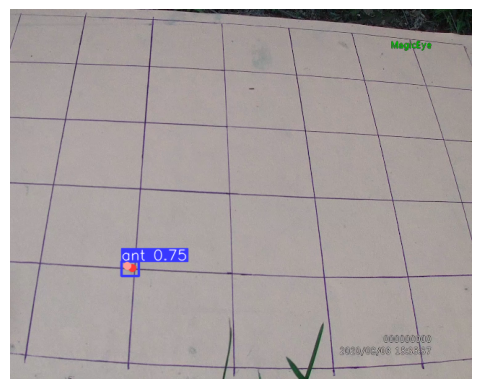

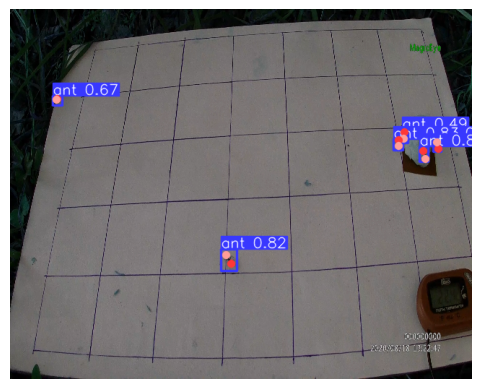

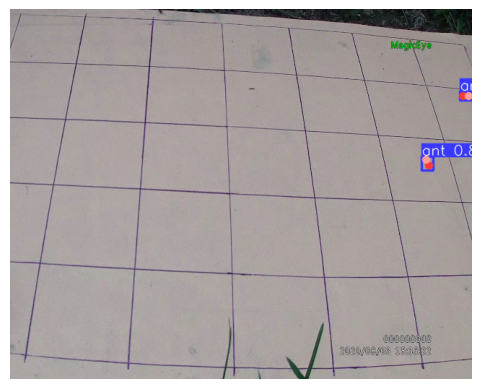

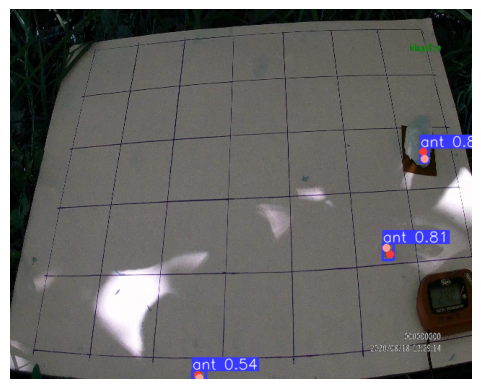

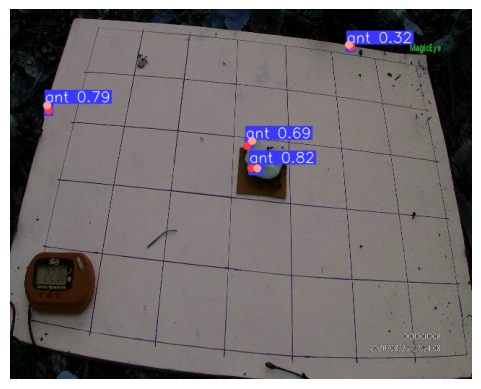

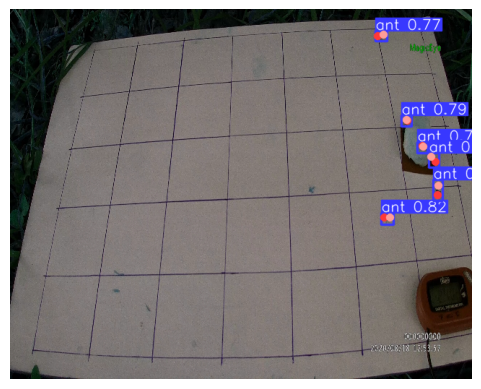

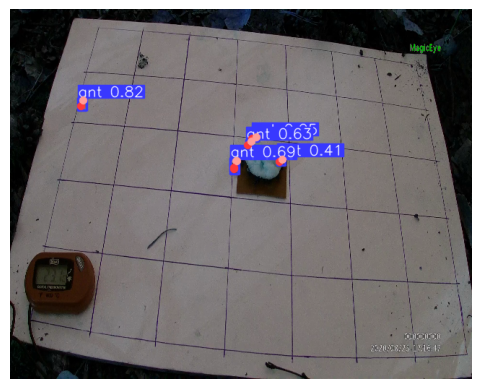

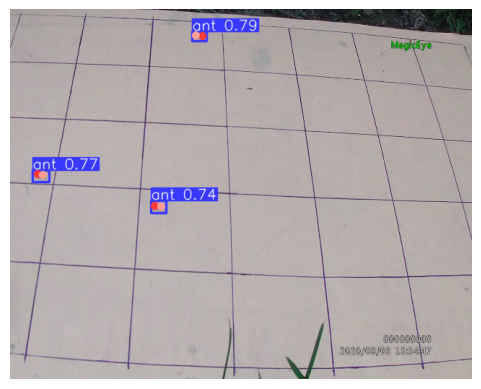

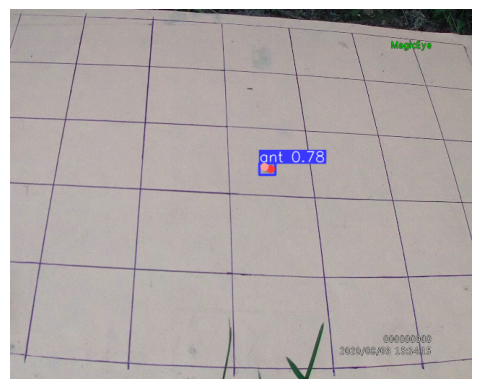

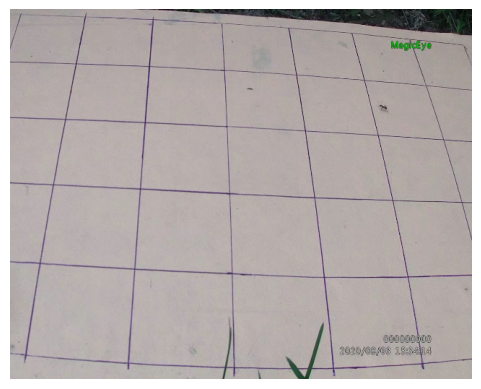

In [ ]:
def predict_all_test_images(test_path):
  """
    Test the trained model on a folder of test images and save the results.

    Args:
        test_image_folder (str): The path to the folder containing test images.

    Returns:
        str: The path to the folder containing the predicted results.
    """

  results = model.predict(source=test_path, save=True)
  return results[0].save_dir

def display_predicted_images(result_path):
  """
  Visualize random selected test predicted images

  Args:
    result_path (str) : Folder containing test images results

  """
  pred_file = glob.glob(os.path.join(result_path, '*'))
  for i in range(10):
    idx = np.random.randint(0, len(pred_file))
    img = cv2.imread(pred_file[idx])
    plt.imshow(img)
    plt.axis('off')
    plt.show()

#Predict trained model upon all images
test_path = '/content/ant-bbox-keypoint-for-yolov8/ant_albumentation/images/test'
result_path = predict_all_test_images(test_path)
display_predicted_images(result_path)

### **Predict Single Image**

In [ ]:
def predict_single_test_image(test_image_path):
  """
  Predict bounding boxes, keypoints, and class for a single test image.

  Args:
    test_image_path (str) : Path of test image

  Returns:
    pred_bbox (list) : A list containing predicted normalized bounding boxes coordinates
    pred_keypoint (list) : A list comprised of all normalized keypoints
    pred_cls (list) : A list of predicted class
  """
   # Use the trained model to predict on the test image
  results = model.predict(source=test_image_path, save=True)

  #Extract Predicted Information
  pred_bbox = results[0].boxes.xywhn.cpu().numpy() #normalized x_y center, width and height
  pred_cls  = results[0].boxes.cls.cpu().numpy()   #predict class
  pred_keypoint = results[0].keypoints.xyn.cpu().numpy()  #pred keypoints
  return pred_cls, pred_bbox, pred_keypoint

In [ ]:
def calculate_iou(pred, gnd):
  """
  Calculate Intersection over union (IoU) between predicted and actual labels

  Args:
    pred (list) : Predicted Bounding boxes Coordinates [x, y, width, height]
    gnd (list)  : Ground Truth Bounding boxes Coordinates [x, y, width, height]

  Return:
    float : Intersection over Union (IoU) score
  """

  x1 = max(gnd[0], pred[0])
  y1 = max(gnd[1], pred[1])
  x2 = min(gnd[0] + gnd[2], pred[0] + pred[2])
  y2 = min(gnd[1] + gnd[3], pred[1] + pred[3])

  intersect  = max(0, x2 - x1) * max(0, y2 - y1)

  area_gnd  = gnd[2] * gnd[3]
  area_pred = pred[2] * pred[3]
  union = area_gnd + area_pred - intersect

  return intersect/union if union > 0 else 0.0

In [ ]:

def calculate_bbox_iou_and_mse(actual_labels, predicted_bboxes, predicted_keypoints):
    """
    Calculate the mean Intersection over Union (IoU) and Mean Squared Error (MSE) between
    actual and predicted labels.

    Args:
        actual_labels (list of str): Ground truth label data.
        predicted_bboxes (list of list): Predicted bounding boxes coordinates.
        predicted_keypoints (list of list): Predicted keypoints coordinates.

    Returns:
        str: A formatted string containing the BBox Mean IOU.
        str: A formatted string containing the Mean Squared Error (MSE).
    """
    if not predicted_bboxes.any():
        return 'BBox Mean IOU: 0.0', 'Mean Squared Error: 0.0'

    ious, mse_error = [], 0

    for gnd in actual_labels:
        #Extract bboxes and keypoints from ground truth labels
        gnd_values = list(map(float, gnd.strip().split(' ')))
        #Calculating IoU
        iou_values = [calculate_iou(pb, gnd_values[1:5]) for pb in predicted_bboxes]
        #Find predicted bbox having max IoU with truth labels
        max_iou_index = np.argmax(iou_values)
        ious.append(np.max(iou_values))
        #Calculate MSE between actual and predicted keypoints
        mse_error += mse(predicted_keypoints[max_iou_index], (gnd_values[5:7], gnd_values[7:]))
    #Calculate mean IoU
    mean_iou = np.mean(ious) * 100
    mean_squared_error = mse_error / len(predicted_bboxes)

    return f'BBox Mean IOU: {mean_iou:.2f}', f'Mean Squared Error: {mean_squared_error:.8f}'


In [ ]:
test_image_path = '/content/ant-bbox-keypoint-for-yolov8/ant_albumentation/images/test/000504.png'
test_label_path = '/content/ant-bbox-keypoint-for-yolov8/ant_albumentation/labels/test/000504.txt'

with open(test_label_path, 'r') as f:
  actual_labels = f.readlines()

pred_cls, pred_bbox, pred_keypoint = predict_single_test_image(test_image_path)
calculate_bbox_iou_and_mse(actual_labels, pred_bbox, pred_keypoint)


image 1/1 /content/ant-bbox-keypoint-for-yolov8/ant_albumentation/images/test/000504.png: 512x640 5 ants, 220.2ms
Speed: 4.0ms preprocess, 220.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)
Results saved to runs/pose/predict


('BBox Mean IOU: 72.53', 'Mean Squared Error: 0.00000168')